✅ Loaded 26 samples | shape: xyz (26, 432, 42, 3), emg (26, 432, 16)


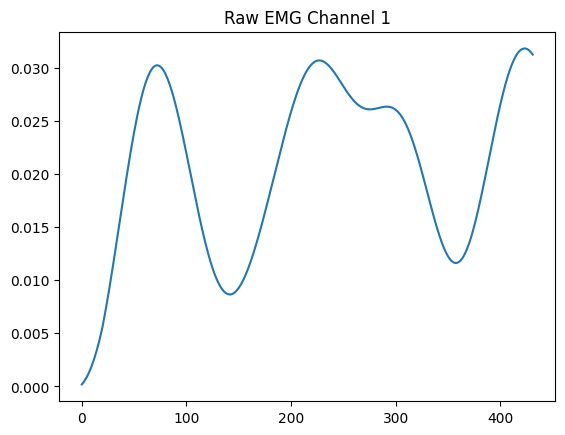

EMG min/max before smoothing: -2.4569747933234294 13.293194200681839
Epoch 1/30, Loss: 0.8945
Epoch 2/30, Loss: 0.6992
Epoch 3/30, Loss: 0.6086
Epoch 4/30, Loss: 0.5261
Epoch 5/30, Loss: 0.4792
Epoch 6/30, Loss: 0.4565
Epoch 7/30, Loss: 0.4215
Epoch 8/30, Loss: 0.4097
Epoch 9/30, Loss: 0.3585
Epoch 10/30, Loss: 0.3374
Epoch 11/30, Loss: 0.3270
Epoch 12/30, Loss: 0.2909
Epoch 13/30, Loss: 0.2757
Epoch 14/30, Loss: 0.2775
Epoch 15/30, Loss: 0.2564
Epoch 16/30, Loss: 0.2507
Epoch 17/30, Loss: 0.2367
Epoch 18/30, Loss: 0.2258
Epoch 19/30, Loss: 0.2230
Epoch 20/30, Loss: 0.2130
Epoch 21/30, Loss: 0.2086
Epoch 22/30, Loss: 0.2023
Epoch 23/30, Loss: 0.1968
Epoch 24/30, Loss: 0.1861
Epoch 25/30, Loss: 0.2122
Epoch 26/30, Loss: 0.2121
Epoch 27/30, Loss: 0.2155
Epoch 28/30, Loss: 0.2025
Epoch 29/30, Loss: 0.2097
Epoch 30/30, Loss: 0.2109

Evaluation Metrics:
MSE: 0.0000
MAE: 0.0023
R^2 Score: 0.2647



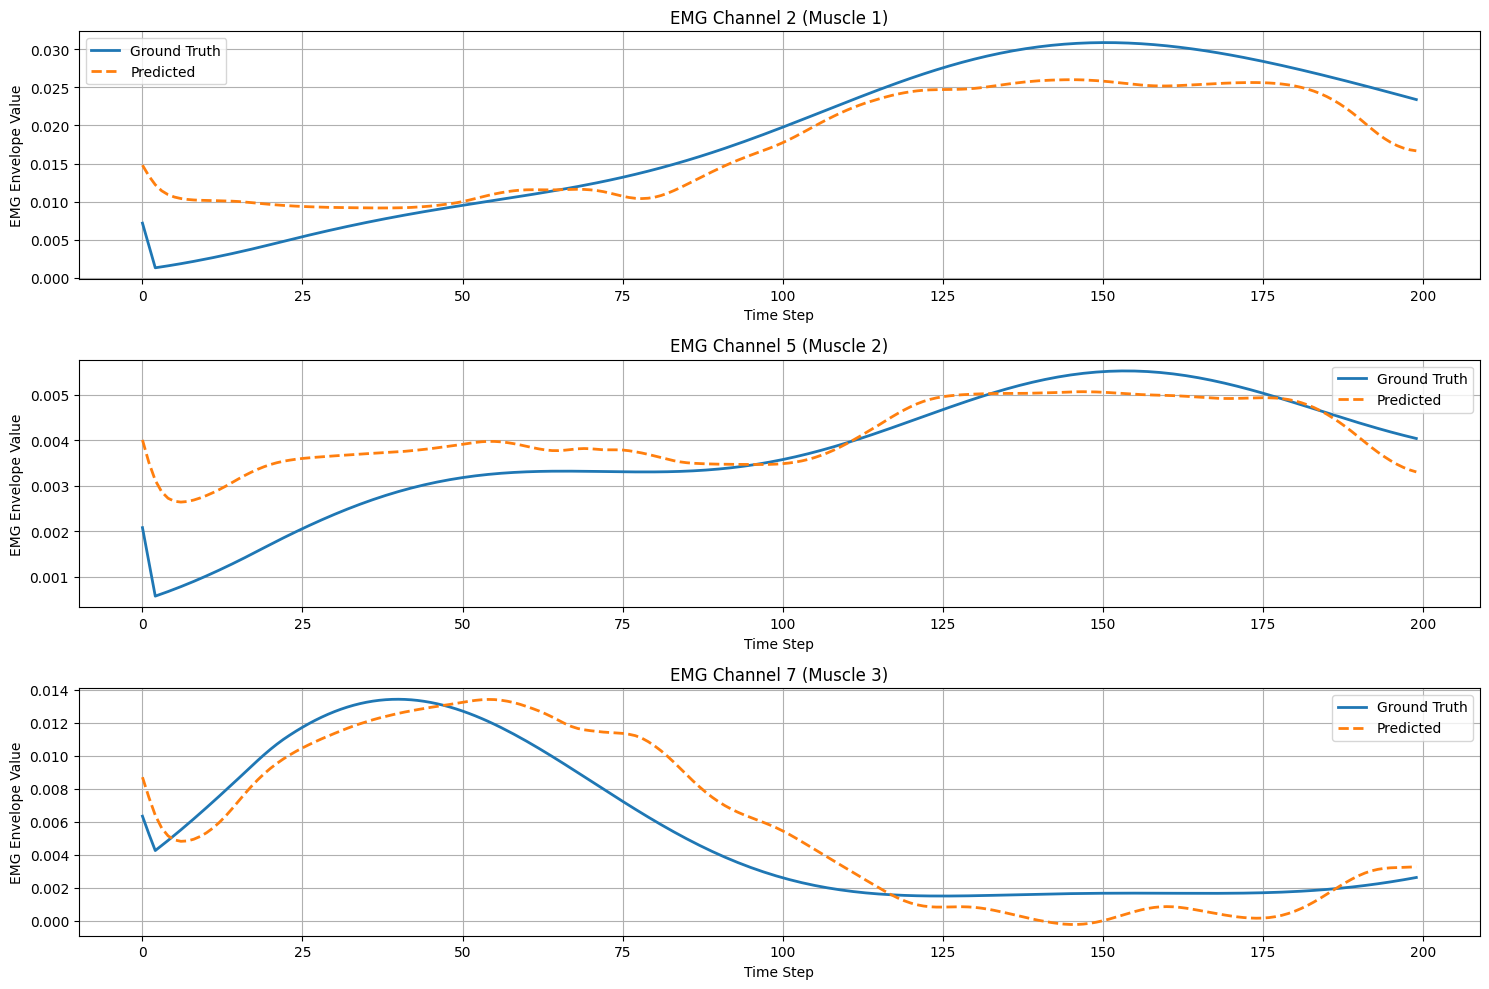

In [ ]:
# Updated LSTM model training code with normalization, seq2seq prediction, better architecture, and fixed-length windows

import torch
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from glob import glob
import pandas as pd


In [ ]:

# =====================
# Configs
# =====================
INPUT_DIM = 126   
         # 42 joints * 3 coords
OUTPUT_DIM = 16            # Number of EMG channels
HIDDEN_DIM = 256
NUM_LAYERS = 2
SEQ_LEN = 200              # Fixed sequence length for training
BATCH_SIZE = 8
EPOCHS = 30
SMOOTH_WINDOW = 5          # For optional smoothing
DATA_FOLDER = "Subject_Data/S5/sync_data/filtered"


In [ ]:

emg_columns = [
    'Tibialis Anterior / Dorsiflexors', 'Gastrocnemius Medial', 'Gastrocnemius Lateral',
    'Hamstrings Lateral', 'Left Lumbars', 'Hamstrings Medial', 'Vastus Lateralis',
    'Vastus Medialis', 'Triceps Brachii', 'Biceps Brachii', 'Forearm M',
    'Middle/Lateral Deltoid', 'Shoulder Flexors', 'Glutei', 'Right Lumbars', 'Rectus Femoris'
]

xyz_cols = [
    'L.FootHeel_X', 'L.FootHeel_Y', 'L.FootHeel_Z',
    'L.AnkleLateral_X', 'L.AnkleLateral_Y', 'L.AnkleLateral_Z',
    'L.AnkleMedial_X', 'L.AnkleMedial_Y', 'L.AnkleMedial_Z',
    'L.ToeLateral_X', 'L.ToeLateral_Y', 'L.ToeLateral_Z',
    'L.ToeMedial_X', 'L.ToeMedial_Y', 'L.ToeMedial_Z',
    'L.WristMedial_X', 'L.WristMedial_Y', 'L.WristMedial_Z',
    'L.WristLateral_X', 'L.WristLateral_Y', 'L.WristLateral_Z',
    'L.ShoulderFront_X', 'L.ShoulderFront_Y', 'L.ShoulderFront_Z',
    'L.ShoulderRear_X', 'L.ShoulderRear_Y', 'L.ShoulderRear_Z',
    'L.KneeLateral_X', 'L.KneeLateral_Y', 'L.KneeLateral_Z',
    'L.KneeMedial_X', 'L.KneeMedial_Y', 'L.KneeMedial_Z',
    'L.LowerArmLateral_X', 'L.LowerArmLateral_Y', 'L.LowerArmLateral_Z',
    'L.LowerArmMedial_X', 'L.LowerArmMedial_Y', 'L.LowerArmMedial_Z',
    'R.AnkleLateral_X', 'R.AnkleLateral_Y', 'R.AnkleLateral_Z',
    'R.AnkleMedial_X', 'R.AnkleMedial_Y', 'R.AnkleMedial_Z',
    'R.ToeLateral_X', 'R.ToeLateral_Y', 'R.ToeLateral_Z',
    'R.ToeMedial_X', 'R.ToeMedial_Y', 'R.ToeMedial_Z',
    'R.WristMedial_X', 'R.WristMedial_Y', 'R.WristMedial_Z',
    'R.WristLateral_X', 'R.WristLateral_Y', 'R.WristLateral_Z',
    'R.ShoulderFront_X', 'R.ShoulderFront_Y', 'R.ShoulderFront_Z',
    'R.ShoulderRear_X', 'R.ShoulderRear_Y', 'R.ShoulderRear_Z',
    'R.KneeLateral_X', 'R.KneeLateral_Y', 'R.KneeLateral_Z',
    'R.KneeMedial_X', 'R.KneeMedial_Y', 'R.KneeMedial_Z',
    'R.LowerArmLateral_X', 'R.LowerArmLateral_Y', 'R.LowerArmLateral_Z',
    'R.LowerArmMedial_X', 'R.LowerArmMedial_Y', 'R.LowerArmMedial_Z',
    'LASIS_X', 'LASIS_Y', 'LASIS_Z', 'LPSIS_X', 'LPSIS_Y', 'LPSIS_Z',
    'RASIS_X', 'RASIS_Y', 'RASIS_Z', 'RPSIS_X', 'RPSIS_Y', 'RPSIS_Z',
    'C7_X', 'C7_Y', 'C7_Z', 'CLAV_X', 'CLAV_Y', 'CLAV_Z',
    'LACR_X', 'LACR_Y', 'LACR_Z', 'RACR_X', 'RACR_Y', 'RACR_Z',
    'Head_Top_X', 'Head_Top_Y', 'Head_Top_Z',
    'R.UpparArm_X', 'R.UpparArm_Y', 'R.UpparArm_Z',
    'L.UpparArm_X', 'L.UpparArm_Y', 'L.UpparArm_Z',
    'R.Thigh_X', 'R.Thigh_Y', 'R.Thigh_Z',
    'L.Thigh_X', 'L.Thigh_Y', 'L.Thigh_Z',
    'R.Shank_X', 'R.Shank_Y', 'R.Shank_Z',
    'L.Shank_X', 'L.Shank_Y', 'L.Shank_Z',
    'RFAsuperior_X', 'RFAsuperior_Y', 'RFAsuperior_Z',
    'LFAsuperior_X', 'LFAsuperior_Y', 'LFAsuperior_Z'
]


In [ ]:

# =====================
# Smoothing Function
# =====================
def smooth(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

# =====================
# Dataset Class
# =====================
class MoCapEMGDataset(Dataset):
    def __init__(self, xyz, emg, xyz_scaler=None, emg_scaler=None):
        self.X = []
        self.y = []

        # Normalize
        self.xyz_scaler = xyz_scaler if xyz_scaler else StandardScaler()
        self.emg_scaler = emg_scaler if emg_scaler else StandardScaler()

        flat_xyz = xyz.reshape(-1, 126)
        flat_emg = emg.reshape(-1, OUTPUT_DIM)

        self.xyz_scaler.fit(flat_xyz)
        self.emg_scaler.fit(flat_emg)

        norm_xyz = self.xyz_scaler.transform(flat_xyz).reshape(xyz.shape)
        norm_emg = self.emg_scaler.transform(flat_emg).reshape(emg.shape)

        print("EMG min/max before smoothing:", norm_emg.min(), norm_emg.max())


        # Optional smoothing of EMG
        for i in range(norm_emg.shape[0]):
            for j in range(norm_emg.shape[2]):
                norm_emg[i, :, j] = smooth(norm_emg[i, :, j], SMOOTH_WINDOW)

        for i in range(xyz.shape[0]):
            seq_len = xyz.shape[1]
            for j in range(0, seq_len - SEQ_LEN, SEQ_LEN):
                self.X.append(norm_xyz[i, j:j+SEQ_LEN].reshape(SEQ_LEN, -1))
                self.y.append(norm_emg[i, j:j+SEQ_LEN])

        self.X = torch.tensor(np.stack(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.stack(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# =====================
# LSTM Model (seq2seq with dropout)
# =====================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

def load_data():
    xyz_list = []
    emg_list = []
    min_len = np.inf

    temp_xyz = []
    temp_emg = []

    for file in sorted(glob(os.path.join(DATA_FOLDER, "*.csv"))):
        df = pd.read_csv(file)

        if not all(col in df.columns for col in xyz_cols + emg_columns):
            print(f"Skipping {file}: missing columns")
            continue

        xyz_vals = df[xyz_cols].values
        emg_vals = df[emg_columns].values

        if xyz_vals.shape[1] != 126 or xyz_vals.shape[0] != emg_vals.shape[0]:
            print(f"Skipping {file}: invalid shape")
            continue

        T = xyz_vals.shape[0]
        min_len = min(min_len, T)
        temp_xyz.append(xyz_vals.reshape(T, 42, 3))
        temp_emg.append(emg_vals)

    # Truncate to minimum sequence length
    for x, e in zip(temp_xyz, temp_emg):
        xyz_list.append(x[:min_len])
        emg_list.append(e[:min_len])

    xyz = np.stack(xyz_list)
    emg = np.stack(emg_list)

    print(f"✅ Loaded {len(xyz)} samples | shape: xyz {xyz.shape}, emg {emg.shape}")
    return xyz, emg



In [ ]:

# =====================
# Training Loop
# =====================
xyz, emg = load_data()
import matplotlib.pyplot as plt
plt.plot(emg[0][:, 0])  # EMG channel 0 of sample 0
plt.title("Raw EMG Channel 1")
plt.show()


dataset = MoCapEMGDataset(xyz, emg)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = LSTMModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")

# Save model
torch.save(model.state_dict(), "lstm_seq2seq.pth")


In [ ]:

# =====================
# Evaluation and Plotting
# =====================
def plot_predictions(model, dataset, emg_scaler, channels):
    model.eval()
    X_sample, y_sample = dataset[2]
    with torch.no_grad():
        X_sample = X_sample.unsqueeze(0)
        y_pred = model(X_sample).squeeze(0).numpy()

    y_true = y_sample.numpy()

    # Denormalize
    y_pred_denorm = emg_scaler.inverse_transform(y_pred)
    y_true_denorm = emg_scaler.inverse_transform(y_true)

    # Compute metrics
    mse = mean_squared_error(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    r2 = r2_score(y_true_denorm, y_pred_denorm)
    print(f"\nEvaluation Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}\n")

    time_axis = np.arange(y_true.shape[0])

    plt.figure(figsize=(15, 10))
    for i, ch_idx in enumerate(channels):
        plt.subplot(len(channels), 1, i + 1)
        plt.plot(time_axis, y_true_denorm[:, ch_idx], label='Ground Truth', linewidth=2)
        plt.plot(time_axis, y_pred_denorm[:, ch_idx], '--', label='Predicted', linewidth=2)
        plt.title(f'EMG Channel {ch_idx + 1} (Muscle {i + 1})')
        plt.xlabel("Time Step")
        plt.ylabel("EMG Envelope Value")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call plot after training
plot_predictions(model, dataset, dataset.emg_scaler, channels=[1,4,6])
